In [1]:
import numpy as np
from numpy import array as arr
from scipy.integrate import cumtrapz#, odeint
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
#%% Define parameters

Mp = 1
gstar = 228.75

Qmin = 10
Qmax = 150
numQ = 1#6
Qrange = np.linspace(Qmin, Qmax, numQ)

fval = Mp
mvalexp = -2
mval = 10**mvalexp * Mp

In [3]:
#%% Define functions

def V(phi, f, m):
    pot = (m*f)**2 * (1 + np.cos(phi/f))
    return pot

def dVdphi(phi, f, m):
    return -m**2 * f * np.sin(phi/f)

def H(phi, phid, rho, f, m):
    hubble = np.sqrt( 1/(3*Mp**2) * ( V(phi, f, m) + 1/2 * phid**2 + rho ) )
    return hubble

def backgroundEoms(IC, t, f, m, Q):
    phi, phid, rho = IC
    phidd = -3*H(phi, phid, rho, f, m)*(1+Q)*phid - dVdphi(phi, f, m)
    rhod = -4*H(phi, phid, rho, f, m)*rho + 3*H(phi, phid, rho, f, m)*Q*phid**2
    return [phid, phidd, rhod]

def find_nearest(array, value):
    array = np.asarray(array)
    index = (np.abs(array - value)).argmin()
    return index

In [4]:
#%% Solve background equations of motion

# NOTE: THIS CODE IS ONLY SET UP TO RUN FOR MULTIPLE VALUES OF Q FOR THE
#       COMPUTATION OF HORIZON-CROSSING VALUES OF BACKGROUND QUANTITIES.
#       THE INTERPOLATION COMPUTATION AT THE END ONLY WORKS FOR RUNNING A
#       SINGLE VALUE OF Q AT A TIME.

# Ntime = 10**5 + 1
ti = 0.
# tf = 10**3
dt = 10**-2#-3 for mval=Mp #(tf - ti) / Ntime

inf0 = 10**-3
infd0 = 10**-3

Nend = [0] * numQ
indHc = [0] * numQ
timeHc = [0] * numQ
Hhc = [0] * numQ
infdHc = [0] * numQ
radHc = [0] * numQ

for i in range(numQ):
    
    Qval = Qrange[i]
    time = [ti]#np.linspace(ti, tf, Ntime)
    rad0 = Qval*infd0**2 / 4
    ic = [inf0, infd0, rad0]
    
    newic = ic
    
    infsoln = [inf0]
    infdsoln = [infd0]
    radsoln = [rad0]
    
    Hi = H(inf0, infd0, rad0, fval, mval)
    Hsoln = [Hi]
    eHi = 0.
    eHsoln = [eHi]
    
    # backgroundSoln = odeint(backgroundEoms, ic, time, args=(fval, mval, Qval))
    
    while eHsoln[-1] < 1:
        derivs = backgroundEoms(newic, time[-1], fval, mval, Qval)
        
        dinf = derivs[0] * dt
        dinfd = derivs[1] * dt
        drad = derivs[2] * dt
        
        infnew = infsoln[-1] + dinf
        infdnew = infdsoln[-1] + dinfd
        radnew = radsoln[-1] + drad
        
        infsoln.append(infnew)
        infdsoln.append(infdnew)
        radsoln.append(radnew)
        
        Hnew = H(infnew, infdnew, radnew, fval, mval)
        Hsoln.append(Hnew)
        
        Hd = (Hsoln[-1] - Hsoln[-2]) / dt
        eHnew = -Hd / Hnew**2
        eHsoln.append(eHnew)
        
        newic = [infnew, infdnew, radnew]
        
        tnew = time[-1] + dt
        time.append(tnew)
    
    infsoln = arr(infsoln)
    infdsoln = arr(infdsoln)
    radsoln = arr(radsoln)
    
    Hsoln = arr(Hsoln)
    eHsoln = arr(eHsoln)
    
    Vsoln = V(infsoln, fval, mval)
    # Hsoln = H(infsoln, infdsoln, radsoln, fval, mval)
    # eHsoln = -np.gradient(Hsoln, time) / (Hsoln**2)
    # etaHsoln = np.gradient(eHsoln, time) / (Hsoln * eHsoln)
    
    # timeInf = time[:indEnd+1]
    # Ne = cumtrapz(Hsoln[:indEnd+1], timeInf, initial=0)
    Ne = cumtrapz(Hsoln, time, initial=0)
    Nend[i] = Ne[-1]
    
    indHc[i] = find_nearest(Ne, Nend[i]-55)
    timeHc[i] = time[indHc[i]]
    
    Hhc[i] = Hsoln[indHc[i]]
    infdHc[i] = infdsoln[indHc[i]]
    radHc[i] = radsoln[indHc[i]]
    
    print("Q = " + str(Qval) + " done")

Q = 10.0 done


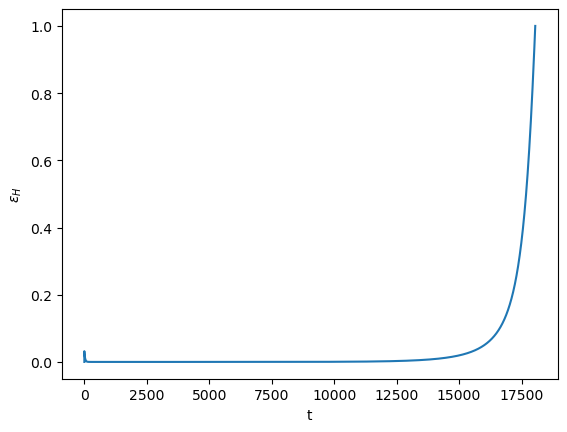

In [5]:
#%% Plot eH

plt.xlabel('t')
plt.ylabel(r'$\epsilon_H$')
plt.plot(time, eHsoln)

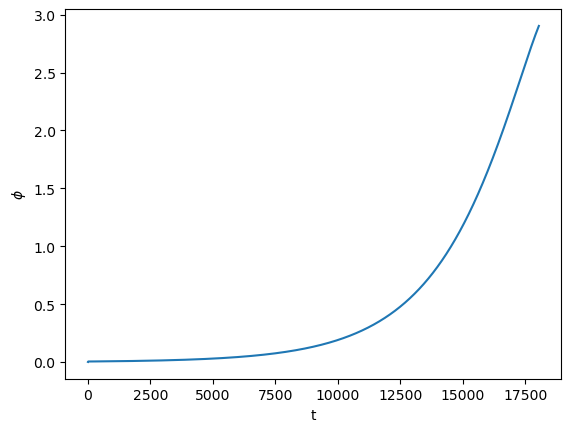

In [6]:
#%% Plot inflaton solution

plt.xlabel('t')
plt.ylabel(r'$\phi$')
plt.plot(time, infsoln)

In [ ]:
#%% Plot radiation energy density solution

plt.xlabel('t')
plt.ylabel(r'$\rho$')
plt.plot(time, radsoln)

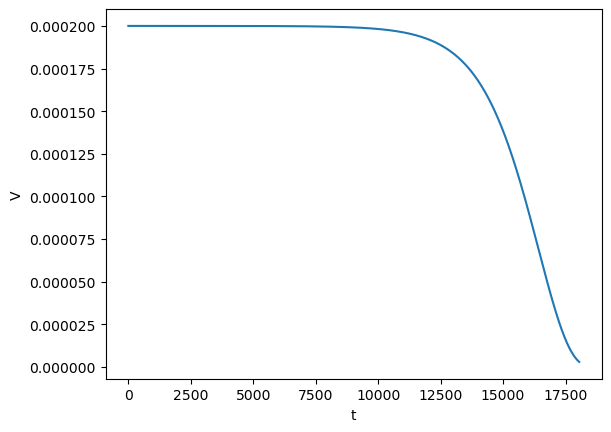

In [7]:
#%% Plot potential

plt.xlabel('t')
plt.ylabel('V')
plt.plot(time, Vsoln)

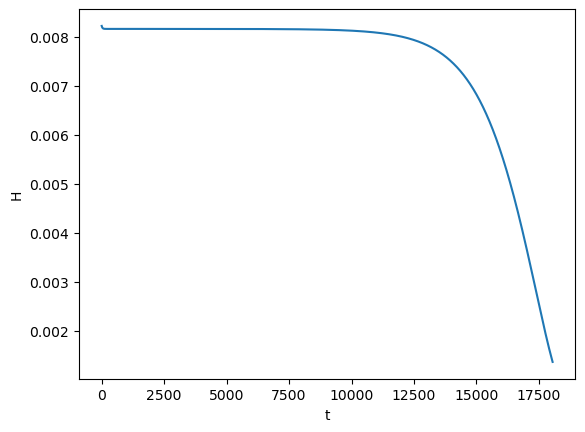

In [8]:
#%% Plot H

plt.xlabel('t')
plt.ylabel('H')
plt.plot(time, Hsoln)

In [ ]:
#%% Plot etaH

plt.xlabel('t')
plt.ylabel(r'$\eta_H$')

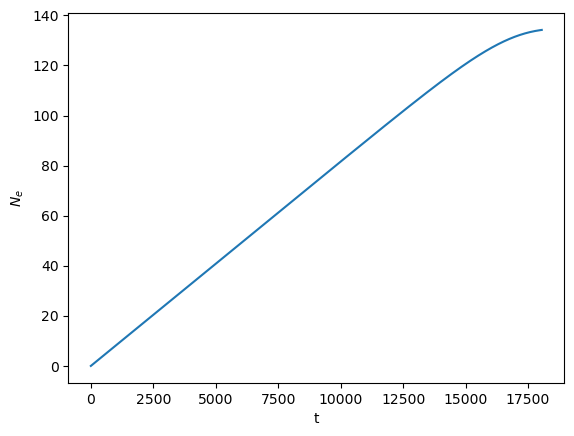

In [9]:
#%% Plot efolds

plt.xlabel('t')
plt.ylabel(r'$N_e$')
# plt.plot(timeInf, Ne)
plt.plot(time, Ne)

In [ ]:
#%% Store horizon crossing values

dataHc = arr([indHc, timeHc, Hhc, infdHc, radHc])
dataHc = dataHc.T

path  = '/Users/vikasaragam/Documents/Python/'
path_file = path + 'results_backgroundHc_constantQ_f' + str(fval) + '_m1e' + str(mvalexp) + 'Mp_index_time_H_phidot_rhorad.txt'
np.savetxt(path_file, dataHc)

In [10]:
#%% Interpolate solution using cubic spline

infSpline = CubicSpline(time,infsoln)
infdSpline = CubicSpline(time,infdsoln)
radSpline = CubicSpline(time,radsoln)
HSpline = CubicSpline(time,Hsoln)
eHSpline = CubicSpline(time,eHsoln)

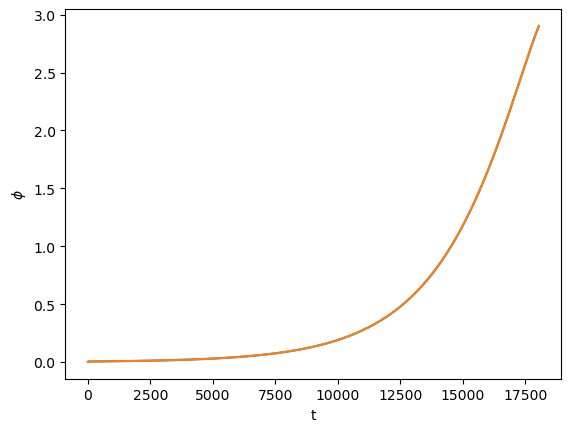

In [11]:
#%% Plot interpolation against actual solution

plt.xlabel('t')
plt.ylabel(r'$\phi$')
plt.plot(time, infsoln, time, infSpline(time))

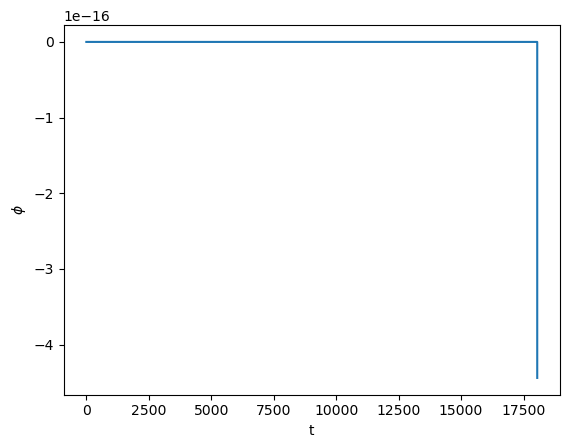

In [12]:
#%% Plot difference between interpolation and actual solution

plt.xlabel('t')
plt.ylabel(r'$\phi$')
plt.plot(time, infsoln - infSpline(time))

In [13]:
#%% Compute cosmic time at which q = ln(z) = ln(k/(aH)) = 6
# q=6 is when we start running the perturbations; if starting from a different q, adjust accordingly

qi = 6#np.log(zi)# 6 to match Luca
qf = 0#np.log(zf)# -4 to match Luca

ztime = np.exp( Nend[0] - 55 - Ne) * Hhc[0] / Hsoln
qztime = np.log(ztime)
indq6 = find_nearest(qztime, qi)
t6 = time[indq6]

# When running perturbations from q=6 to q=0, sample background from t6 to timeHc

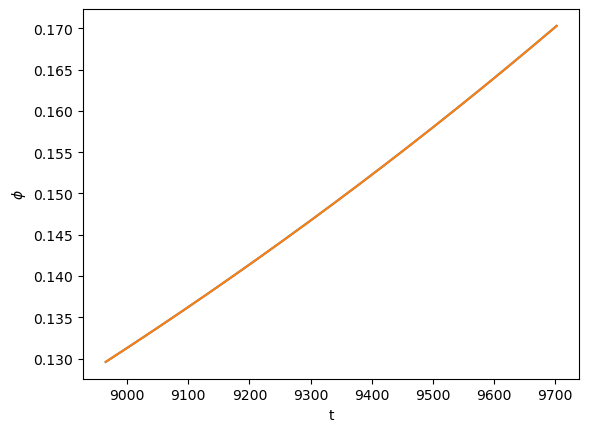

In [14]:
#%% Plot interpolation against actual solution from t6 to timeHc

plt.xlabel('t')
plt.ylabel(r'$\phi$')
plt.plot(time[indq6:indHc[0]], infsoln[indq6:indHc[0]], time[indq6:indHc[0]], infSpline(time[indq6:indHc[0]]))

In [15]:
#%% Interpolate solution in q-time

Nq = 10**5# 10**5 to match Luca
dq = (qf - qi)/Nq
qtime = np.linspace(qi, qf, Nq)# Note that this is NOT the same as qztime, which is q(z(time))

# CubicSpline requires independent variable array to be an increasing sequence
# qtime decreases as cosmic time progresses, so the interpolation is done in negative q
negqinfSpline = CubicSpline(-qztime,infsoln)
negqinfdSpline = CubicSpline(-qztime,infdsoln)
negqradSpline = CubicSpline(-qztime,radsoln)
negqHSpline = CubicSpline(-qztime,Hsoln)
negqeHSpline = CubicSpline(-qztime,eHsoln)
# These background splines take in a value of negative q and output the background solution at that time
# Just remember to input the negative of the desired value of q!

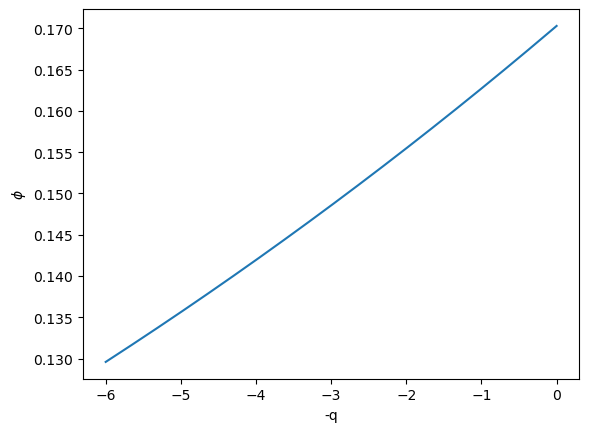

In [16]:
#%% Plot interpolation against actual solution from -qi to -qf

plt.xlabel('-q')
plt.ylabel(r'$\phi$')

plt.plot(-qtime, negqinfSpline(-qtime))